In [ ]:
import cv2
from skimage import io
import numpy as np
from PIL import Image
import cc3d
# from cloudvolume import CloudVolume, view
import matplotlib.pyplot as plt

src = '/home/pxl/myProject/血管分割/molong-resource/true_3044_e03e0573e1ea98fe3f48.png' # 480*480

def twod(src):
  img = Image.open(src)
  return np.array(img)[:,:,0]

def maxFilter(img, kernel_size):
  max_filtered_image = cv2.dilate(img, np.ones((kernel_size, kernel_size), np.uint8))
  return max_filtered_image

def minFilter(img, kernel_size=6):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    min_filtered_image = cv2.erode(img, kernel)
    return min_filtered_image

def downsample_image(image, scale=0.5):
    # 计算降采样后的尺寸
    new_width = int(image.shape[1] * scale)
    new_height = int(image.shape[0] * scale)
    # 图像降采样
    downsampled_img = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)
    return downsampled_img

"""
根据给定的比例系数分割图像成多个块。参数:
mg (np.ndarray): 输入图像。
cale_factor (float): 块相对于图像尺寸的比例。
返回:
list: 包含所有块的列表。
"""
def split_image_into_tiles(img, scale_factor):
    height, width = img.shape[:2]
    # 计算基于最小边的块大小
    tile_size = int(min(height, width) * scale_factor)

    tiles = []
    for y in range(0, height, tile_size):
        for x in range(0, width, tile_size):
            tiles.append(img[y:y+tile_size, x:x+tile_size])
    return tiles

# labels, numcomp = cc3d.connected_components(imageArr,return_N=True)

# # 计算并打印连通分量标签的数量（即有多少个不同的连通分量）
# print(numcomp)
# view(labels, segmentation=True)

# np.savetxt('/home/pxl/myProject/血管分割/molong-resource/二维码image.txt', imageArr, fmt='%d')

In [ ]:
"""
图像降采样（Downsampling）
"""
import matplotlib.pyplot as plt

imageArr = twod(src) # (480*480)
# print(np.size(imageArr[:][0]))
# imageArrF = minFilter(imageArr,10) 
imageArrF = downsample_image(imageArr,0.1) 

fig, axs = plt.subplots(1, 2)
axs[0].imshow(imageArr)
axs[0].set_title('原始图像')
axs[0].axis('off')
axs[1].imshow(imageArrF)
axs[1].set_title('处理后图像')
axs[1].axis('off')
plt.show()

print(imageArr.shape)
print(imageArrF.shape)



In [ ]:
"""
分块处理（Tiling or Windowing）
"""
import matplotlib.pyplot as plt

scale_factor = 0.5  # 希望块大小为图像尺寸的10%
imageArr = twod(src) # (480*480)

# 裁剪图像到可以整齐分块的大小
tile_size = int(imageArr.shape[0] * scale_factor) # int很重要
crop_size = int(tile_size * scale_factor * 100)
imageArr_cropped = imageArr[:crop_size, :crop_size]

tiles = split_image_into_tiles(imageArr_cropped, scale_factor)

print(crop_size)
print(imageArr_cropped.shape)
print(len(imageArr[0]))
print(len(tiles))
print(tiles[0].shape)

# 计算图像分块后的行列数，并确保它们是整数
n_cols = int(crop_size // tile_size)  # 列数
n_rows = int(crop_size // tile_size)  # 行数
fig, axs = plt.subplots(n_rows, n_cols)

# 展示每个 tile
for i, tile in enumerate(tiles):
    ax = axs[i // n_cols, i % n_cols]
    ax.imshow(tile)
    ax.axis('off')

# 隐藏未使用的子图
for i in range(len(tiles), n_rows * n_cols):
    axs[i // n_cols, i % n_cols].axis('off')

plt.show()

# np.savetxt('/home/pxl/myProject/血管分割/molong-resource/二维码image.txt', tiles[0], fmt='%d')



In [ ]:
"""
图像金字塔。模糊后，反而会有丢失拓扑精度。但是会在另一种程度上进行拓扑连接。
"""
import cv2
import matplotlib.pyplot as plt

def create_image_pyramid(img, levels):
    """
    创建图像金字塔

    参数:
    img: 输入的图像（灰度图像或彩色图像）。
    levels: 图像金字塔的层数。

    返回:
    pyramid: 包含不同分辨率图像的列表。
    """
    pyramid = [img]
    for i in range(1, levels):
        img = cv2.pyrDown(img)
        pyramid.append(img)
    return pyramid

def visualize_pyramid(pyramid):
    """
    可视化图像金字塔

    参数:
    pyramid: 包含不同分辨率图像的列表。
    """
    num_levels = len(pyramid)
    fig, axs = plt.subplots(1, num_levels, figsize=(30, 10))

    for i in range(num_levels):
        axs[i].imshow(cv2.cvtColor(pyramid[i], cv2.COLOR_BGR2RGB))
        axs[i].set_title(f'Level {i + 1}')
        axs[i].axis('off')

    plt.show()

# 示例使用
img = cv2.imread(src)  # 读取图像

# 创建图像金字塔
levels = 8  # 设置图像金字塔的层数
pyramid = create_image_pyramid(img, levels)

# 可视化图像金字塔
visualize_pyramid(pyramid)

In [2]:
''''
保存txt
'''
from PIL import Image
import numpy as np

# 定义图像路径
path = '/home/pxl/myProject/血管分割/molong-深度插值/molong-work/Unet/wandb/latest-run/files/media/images/pred_prob_369_e564ac44951a60ac6798.png'

# 使用 PIL 读取图像
img = Image.open(path)

# 将图像转换为 numpy 数组
img_array = np.array(img)

np.savetxt('/home/pxl/myProject/血管分割/molong-深度插值/molong-utils/test.txt', img_array[:,:,0], fmt='%d')

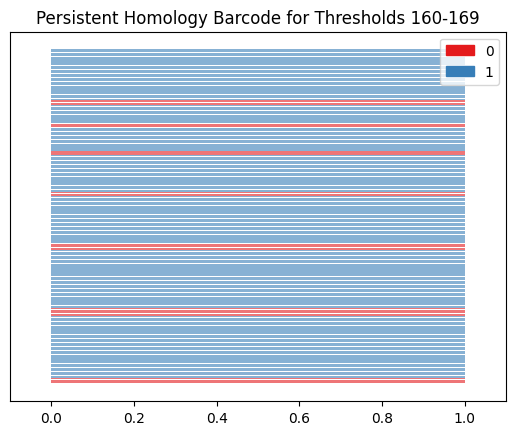

In [3]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import gudhi as gd

# 读取图像并转换为 NumPy 数组
path = '/home/pxl/myProject/血管分割/molong-深度插值/molong-work/Unet/wandb/latest-run/files/media/images/pred_prob_369_e564ac44951a60ac6798.png'
img = Image.open(path).convert('L')  # 将图像转换为灰度模式 ('L' 表示灰度图)
img_array = np.array(img)  # 将像素值标准化为 0 到 255

# 存储每个阈值的持久同调结果
all_persistence = []

# 生成阈值为160到169之间不同结果的图像
thresholds = range(163, 170)  # 注意阈值范围包括 160 到 169
for threshold in thresholds:
    # 对图像进行二值化，阈值之上的设为 1，其他为 0
    binary_img = np.where(img_array >= threshold, 1, 0).astype(np.float64)
    
    # 构建立方复形
    cubical_complex = gd.CubicalComplex(top_dimensional_cells=binary_img)
    
    # 计算持久同调
    persistence = cubical_complex.persistence()

    # 存储持久同调的结果
    all_persistence.extend(persistence)

# 绘制聚合后的持久同调条形码
gd.plot_persistence_barcode(all_persistence)
plt.title("Persistent Homology Barcode for Thresholds 160-169")
plt.show()